In [27]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')

import math
from typing import Any, Dict, List, Optional
from datetime import datetime
import rasterio
import contextily
import geopandas
import haversine as hs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import requests
from tqdm.notebook import tqdm

from huhuha.settings import RAW_DATA_DIR, DATA_DIR
from huhuha.ops_tiles import get_otm_tile
from huhuha.utils import get_elevation, random_float

tqdm.pandas()
sns.set_theme(style='whitegrid')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
# wczytuje dane o lawinach
avalnache_data_path =  RAW_DATA_DIR / 'data-avalanche.csv'
df = pd.read_csv(avalnache_data_path)

In [31]:
# ile mamy
df.shape

(3961, 22)

In [153]:
# czyszcze troche zbior

# usuwam wiersze z brakiem informacji o masywach
df = df.dropna(subset=['massif'])

# usuwam wiersze z brakiem informacji o lokalizacji geograficznej
df = df.dropna(subset=['latitude', 'longitude'])
df = df.drop(df[(df.latitude == 0.0) | (df.longitude == 0.0)].index)

# dropuje wiersze gdzie brak informacji o dacie lawiny
df = df.dropna(subset=['date'])
df['date'] = pd.to_datetime(df['date'], unit='ms')
df['year'] = df['date'].dt.year

In [162]:
# df[df['massif'] == 'Mont Thabor'].groupby('year').count()
df[df['sommet'] == 'Dent Parrachée'].groupby('year').count()

id  date  massif  sommet  itineraire  description  orientation  \
year                                                                   
1995   1     1       1       1           1            1            1   
1997   1     1       1       1           1            1            1   
2005   1     1       1       1           1            1            1   
2007   3     3       3       3           3            2            3   
2009   3     3       3       3           3            3            3   
2010   4     4       4       4           3            3            4   
2011   1     1       1       1           0            1            1   
2012   2     2       2       2           2            2            2   
2013   7     7       7       7           5            7            7   
2014   3     3       3       3           3            1            3   
2016   1     1       1       1           1            1            1   
2017   1     1       1       1           1            1            1   
2018   7     7       7       7           7            4            7   
2019   3     3       3       3           3            1            3   
2020   4     4       4       4           3            4            4   
2021   5     5       5       5           4            4            5   

      caracteristique  origine_principale  origine_secondaire  ...  latitude  \
year                                                           ...             
1995                1                   1                   0  ...         1   
1997                1                   1                   0  ...         1   
2005                1                   1                   0  ...         1   
2007                3                   3                   0  ...         3   
2009                3                   3                   0  ...         3   
2010                4                   4                   1  ...         4   
2011                1                   0                   0  ...         1   
2012                2                   2                   2  ...         2   
2013                7                   6                   0  ...         7   
2014                3                   2                   0  ...         3   
2016                1                   1                   0  ...         1   
2017                1                   1                   1  ...         1   
2018                7                   5                   2  ...         7   
2019                3                   3                   1  ...         3   
2020                4                   3                   2  ...         4   
2021                5                   4                   1  ...         5   

      longitude  thumbnail  imagesNb  isPrivate  tags  updated  \
year                                                             
1995          1          1         1          1     0        1   
1997          1          1         1          1     0        1   
2005          1          1         1          1     0        1   
2007          3          2         3          3     1        3   
2009          3          3         3          3     0        3   
2010          4          3         4          4     0        4   
2011          1          1         1          1     0        1   
2012          2          2         2          2     0        2   
2013          7          7         7          7     1        7   
2014          3          1         3          3     1        3   
2016          1          1         1          1     0        1   
2017          1          1         1          1     0        1   
2018          7          3         7          7     1        7   
2019          3          1         3          3     0        3   
2020          4          4         4          4     0        4   
2021          5          4         5          5     0        5   

      altitude_depart  altitude_arrivee  geometry  
year                       

In [131]:
# il zostalo
df.shape

(3369, 23)

In [132]:
df.head()

id                date             massif  \
0  1642072642225 2022-01-11 23:00:00  aiguilles d arves   
2  1642005733893 2022-01-10 23:00:00    Haute Maurienne   
3  1641931532871 2022-01-10 23:00:00         Belledonne   
4  1641918131562 2022-01-10 23:00:00        Mont Thabor   
5  1641903068359 2022-01-10 23:00:00             Aravis   

                    sommet                                         itineraire  \
0  Aiguille de l'Epaisseur                                                NaN   
2     Pointe de Vallonbrun                                                NaN   
3       pointe du sciallet  Sommet du sciallet par l'éperon est, permettan...   
4        Roche de la Pelle                                                NaN   
5             La Tournette  Itinéraire classique NE, juste en haut du coul...   

                                         description orientation  \
0  b"Apres s'etre decale trop sur la gauche par r...           E   
2  b"Petite avalanche partie spontanement, probab...          SE   
3  b"Declenchement de la plaque par 1 skieur. \r\...           E   
4  b"Avalanche spontanee partie tres probablement...          NE   
5  b'Petite coulee en haut du couloir de la tourn...          NE   

  caracteristique     origine_principale origine_secondaire  ...   latitude  \
0             b''    Ski touring, uphill                NaN  ...  45.130920   
2    b'Wind slab'                    NaN                NaN  ...  45.317667   
3             b''  Ski touring, downhill                NaN  ...  45.212236   
4    b'Soft slab'                    NaN                NaN  ...  45.136030   
5             b''                    NaN                NaN  ...  45.823805   

  longitude                                          thumbnail  imagesNb  \
0  6.357383  /attached-files/thumbnails/1642072461149-IMG20...         2   
2  6.937318  /attached-files/thumbnails/1642005733893-16420...         2   
3  6.013909  /attached-files/thumbnails/1641931326001-inbou...         3   
4  6.551387  /attached-files/thumbnails/1641918131562-16419...         5   
5  6.287098  /attached-files/thumbnails/1641903065699-IMG18...         1   

   isPrivate tags        updated  altitude_depart altitude_arrivee  \
0      False  NaN  1642074353000             3100                0   
2      False  NaN  1642005978000             2630             2240   
3      False  NaN  1641931532000             2300             2200   
4      False  NaN  1641918700000             2820             2450   
5      False  NaN  1641903068000             2330             2320   

                   geometry  
0  POINT (6.35738 45.13092)  
2  POINT (6.93732 45.31767)  
3  POINT (6.01391 45.21224)  
4  POINT (6.55139 45.13603)  
5  POINT (6.28710 45.82381)  

[5 rows x 23 columns]

In [133]:
df.groupby('massif').size().reset_index(name='counts').sort_values('counts', ascending=False).head(20)

massif  counts
49    Haute Maurienne     417
155           Vanoise     365
93             Oisans     248
50   Haute Tarentaise     231
77          Maurienne     185
13             Aravis     158
17         Belledonne     142
80         Mont Blanc     139
118           Queyras     130
16        Beaufortain     101
83        Mont Thabor     101
38             Ecrins      99
67           Lauzière      93
130         Taillefer      78
43    Grandes Rousses      56
25             Cerces      53
31         Chartreuse      39
30          Champsaur      34
158            Vosges      33
135             Ubaye      32

In [134]:
# robie geopandasa
gdf = geopandas.GeoDataFrame(
    df, geometry=geopandas.points_from_xy(df.longitude, df.latitude, crs="EPSG:4326"))

In [135]:
# filtruje pkt dla alp francuskich
ALPS_LAT_LOWER = 44.6
ALPS_LAT_UPPER = 46.1
ALPS_LONG_LOWER = 5.6
ALPS_LONG_UPPER = 7.2

gdf_french_alps = gdf[(gdf.latitude > ALPS_LAT_LOWER) & (gdf.latitude < ALPS_LAT_UPPER) & 
                      (gdf.longitude > ALPS_LONG_LOWER) & (gdf.longitude < ALPS_LONG_UPPER)]

In [136]:
(
    gdf_french_alps
    .groupby('massif')
    .size()
    .reset_index(name='counts')
    .sort_values('counts', ascending=False)
    ['massif']
    .apply(lambda x: x.lower())
    .apply(lambda x: x.replace(' ', '_'))
    .sort_values()
    .to_csv('massif_counts.csv', index=False)
)

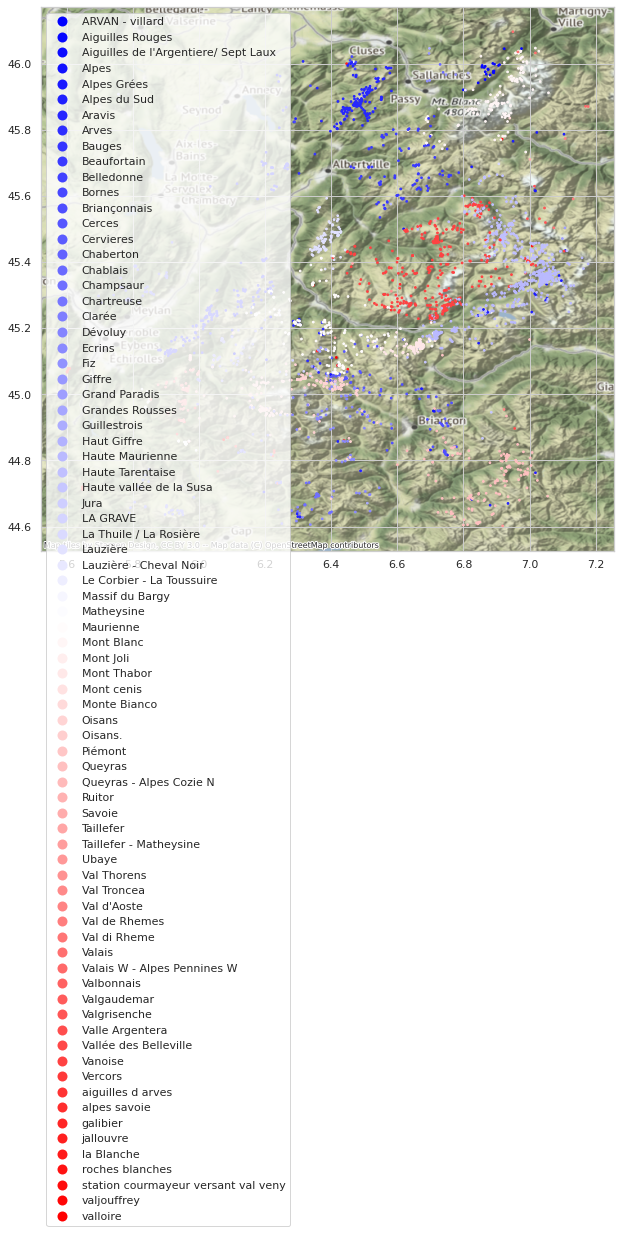

In [137]:
ax = gdf_french_alps.plot(column='massif', categorical=True, markersize=3, 
                    cmap='bwr', figsize=(12, 10), legend=True)
contextily.add_basemap(ax, crs=gdf_french_alps.crs.to_string())

In [138]:
massif_by_number_of_avalanches = (
    gdf_french_alps
    .groupby('massif')
    .size()
    .reset_index(name='counts')
    .sort_values('counts', ascending=False)
)
top_massif = (
    massif_by_number_of_avalanches
    ['massif']
    .head(10)
)

massif_dict_mapper = {
    r['massif']: f"{r['counts']} {r['massif']}"
    for r in massif_by_number_of_avalanches.to_dict(orient='records')
} 


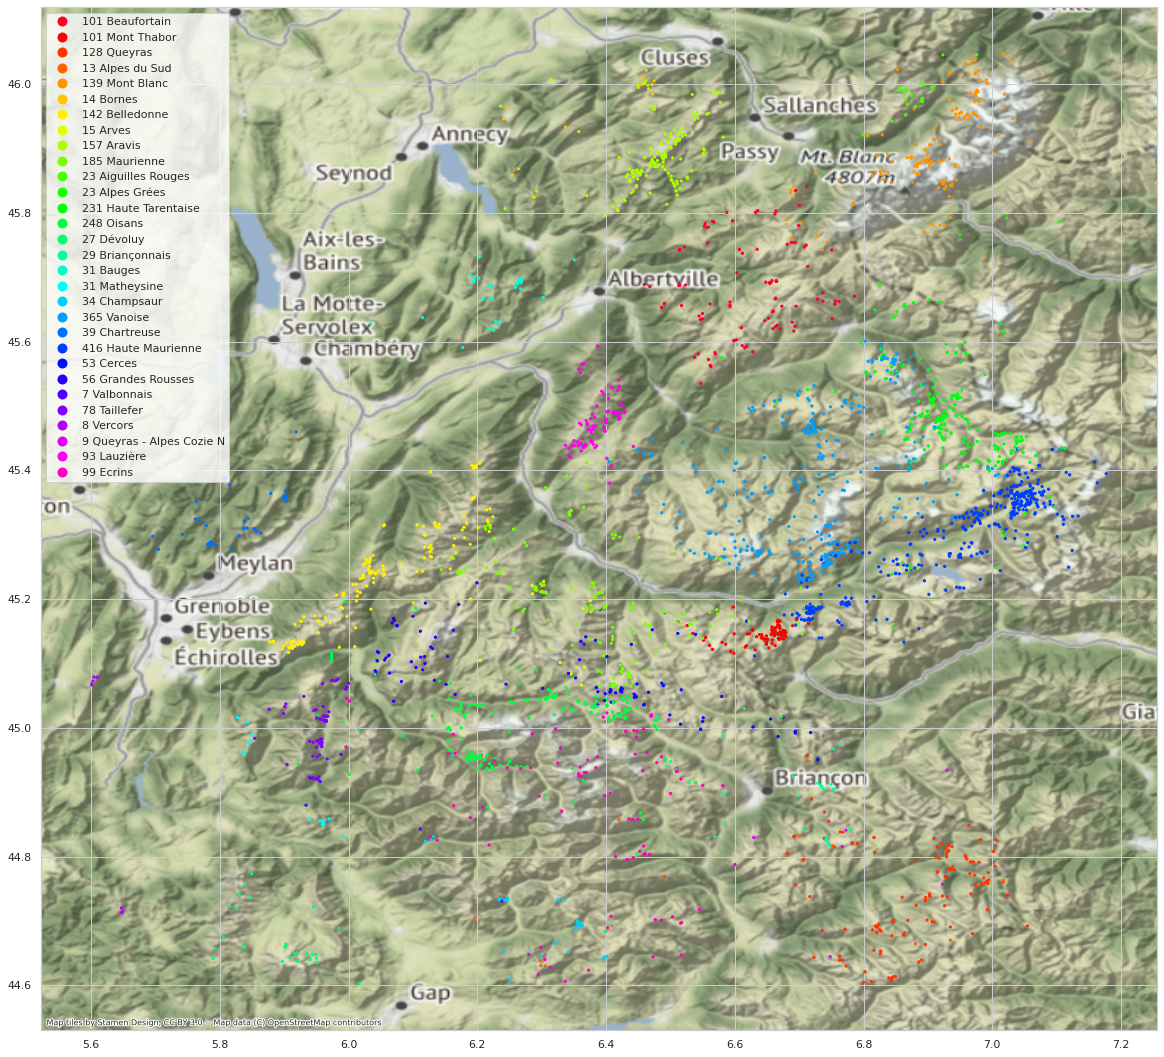

In [139]:
massif_by_number_of_avalanches = (
    gdf_french_alps
    .groupby('massif')
    .size()
    .reset_index(name='counts')
    .sort_values('counts', ascending=False)
)
top_massif = (
    massif_by_number_of_avalanches
    ['massif']
    .head(30)
)

massif_dict_mapper = {
    r['massif']: f"{r['counts']} {r['massif']}"
    for r in massif_by_number_of_avalanches.to_dict(orient='records')
} 



gdf_top_massif = gdf_french_alps[gdf_french_alps.massif.isin(top_massif)]

gdf_top_massif['massif_with_number_of_episodes'] = gdf_top_massif.massif.map(massif_dict_mapper)

ax = gdf_top_massif.plot(
    column='massif_with_number_of_episodes',
    categorical=True,
    markersize=5, 
    cmap='gist_rainbow',
    figsize=(20, 20),
    legend=True
)

contextily.add_basemap(
    ax, 
    crs=gdf_top_massif.crs.to_string()
)

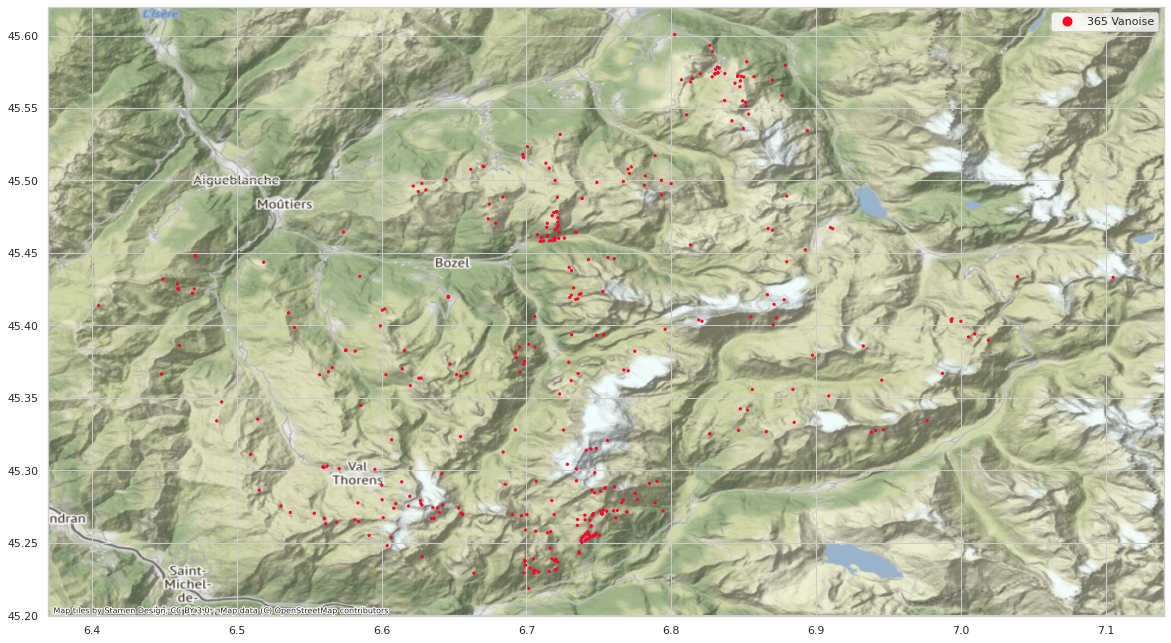

In [159]:
# do tych masywow sie ograniczymy

selected_massif = [
    # 'Aravis',
    # 'Mont Thabor',
    # 'Lauzière',
    'Vanoise'
    

]

gdf_selected_massif = gdf_french_alps[gdf_french_alps.massif.isin(selected_massif)]

gdf_selected_massif['massif_with_number_of_episodes'] = gdf_selected_massif.massif.map(massif_dict_mapper)

ax = gdf_selected_massif.plot(
    column='massif_with_number_of_episodes',
    categorical=True,
    markersize=5, 
    cmap='gist_rainbow',
    figsize=(20, 20),
    legend=True,
)

contextily.add_basemap(
    ax, 
    crs=gdf_selected_massif.crs.to_string()
)

In [160]:
sorted(gdf_french_alps.massif.unique().tolist())

['ARVAN - villard',
 'Aiguilles Rouges',
 "Aiguilles de l'Argentiere/ Sept Laux",
 'Alpes',
 'Alpes Grées',
 'Alpes du Sud ',
 'Aravis',
 'Arves',
 'Bauges',
 'Beaufortain',
 'Belledonne',
 'Bornes',
 'Briançonnais',
 'Cerces',
 'Cervieres',
 'Chaberton',
 'Chablais',
 'Champsaur',
 'Chartreuse',
 'Clarée',
 'Dévoluy',
 'Ecrins',
 'Fiz',
 'Giffre',
 'Grand Paradis',
 'Grandes Rousses',
 'Guillestrois',
 'Haut Giffre',
 'Haute Maurienne',
 'Haute Tarentaise',
 'Haute vallée de la Susa',
 'Jura',
 'LA GRAVE',
 'La Thuile / La Rosière',
 'Lauzière',
 'Lauzière - Cheval Noir',
 'Le Corbier - La Toussuire',
 'Massif du Bargy',
 'Matheysine',
 'Maurienne',
 'Mont Blanc',
 'Mont Joli',
 'Mont Thabor',
 'Mont cenis',
 'Monte Bianco',
 'Oisans',
 'Oisans. ',
 'Piémont',
 'Queyras',
 'Queyras - Alpes Cozie N',
 'Ruitor',
 'Savoie',
 'Taillefer',
 'Taillefer - Matheysine',
 'Ubaye',
 'Val Thorens',
 'Val Troncea',
 "Val d'Aoste",
 'Val de Rhemes',
 'Val di Rheme',
 'Valais',
 'Valais W - Alpes Pe

In [161]:
gdf_selected_massif.groupby('sommet').size().reset_index(name='counts').sort_values('counts', ascending=False)

sommet  counts
31         Dent Parrachée      39
13                Aussois      23
89       Rateau d'Aussois      18
53               Les Arcs      17
18      Champagny-le-haut      14
..                    ...     ...
56            Mont Pourri       1
1          Aiguille Grive       1
54           Les Ménuires       1
16   Champagny en vanoise       1
109                yvoses       1

[110 rows x 2 columns]

In [144]:
gdf_selected_massif.describe()

id    latitude   longitude    imagesNb       updated  \
count  1.940000e+02  194.000000  194.000000  194.000000  1.940000e+02   
mean   9.334105e+11   45.304603    6.526104    2.634021  1.450314e+12   
std    7.456474e+11    0.166594    0.134691    2.596346  1.488001e+11   
min    5.000002e+07   45.115821    6.336875    0.000000  0.000000e+00   
25%    5.000010e+07   45.146636    6.387971    1.000000  1.351141e+12   
50%    1.426925e+12   45.165818    6.557777    2.000000  1.427832e+12   
75%    1.552743e+12   45.473755    6.666504    4.000000  1.558067e+12   
max    1.641918e+12   45.593065    6.714400   18.000000  1.641919e+12   

       altitude_depart  altitude_arrivee  
count       194.000000        194.000000  
mean       2004.474227        979.505155  
std         854.312135       1049.636938  
min           0.000000          0.000000  
25%        1930.000000          0.000000  
50%        2250.000000          0.000000  
75%        2548.750000       2015.000000  
max        3020.000000       2830.000000